# L2: Image captioning app 🎨

In [1]:
%pip install python-dotenv 

Note: you may need to restart the kernel to use updated packages.


## Load HF API key and relevant Python libraries.

Hugging Face "API keys" are called "User Access tokens". A short description how to get your own Hugging Face API key (HF_API_KEY) is given in the file API_keys.txt. 

In [1]:
import os # Provides a way of using operating system-dependent functionality
import io # Provides core tools for working with streams of data
import IPython.display # Used for displaying rich content (e.g., images, HTML) in Jupyter Notebooks
from PIL import Image  # Python Imaging Library for opening, manipulating, and saving image files
import base64 # Encodes and decodes data in base64 format

from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) # read local .env file
hf_api_key = os.environ['HF_API_KEY']
#print(hf_api_key)


The HF_API_ITT_BASE for the image-to-text endpoint is related to the choosen model from image-to-text section that is available on the Hugging Face website's. Here, the selected model is Salesforce/blip-image-captioning-large, which is currently widely used. The corresponding API URL is:"https://api-inference.huggingface.co/models/Salesforce/blip-image-captioning-large"

In [2]:
from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) # read local .env file
ENDPOINT_URL=os.environ['HF_API_ITT_BASE']
#print(ENDPOINT_URL)

KeyError: 'HF_API_ITT_BASE'

In [18]:
# Helper functions
import requests, json

#Image-to-text endpoint
def get_completion(inputs, parameters=None, ENDPOINT_URL=os.environ['HF_API_ITT_BASE']):
    headers = {
      "Authorization": f"Bearer {hf_api_key}",
      "Content-Type": "application/json"
    }
    data = { "inputs": inputs }
    if parameters is not None:
        data.update({"parameters": parameters})
    response = requests.request("POST",
                                ENDPOINT_URL,
                                headers=headers,
                                data=json.dumps(data))
    return json.loads(response.content.decode("utf-8"))

## Building an image captioning app 

Here we'll be using an [Inference Endpoint](https://huggingface.co/inference-endpoints) for `Salesforce/blip-image-captioning-base` a 14M parameter captioning model.

The free images are available on: https://free-images.com/

image_url = "https://free-images.com/sm/9596/dog_animal_greyhound_983023.jpg"
display(IPython.display.Image(url=image_url))
get_completion(image_url)

In [19]:
#helper function to import load_image, get_generation (see Quantization Fundamentals with Hugging Face/Models with different data types)
import torch
import torch.nn as nn
import requests
from PIL import Image

import warnings
# Ignore specific UserWarnings related to max_length in transformers
warnings.filterwarnings("ignore", 
    message=".*Using the model-agnostic default `max_length`.*")

#get_generation
def get_generation(model, processor, image, dtype):
  inputs = processor(image, return_tensors="pt").to(dtype)
  out = model.generate(**inputs)
  return processor.decode(out[0], skip_special_tokens=True)

#load_image

def load_image(img_url):
    image = Image.open(requests.get(
        img_url, stream=True).raw).convert('RGB')

    return image


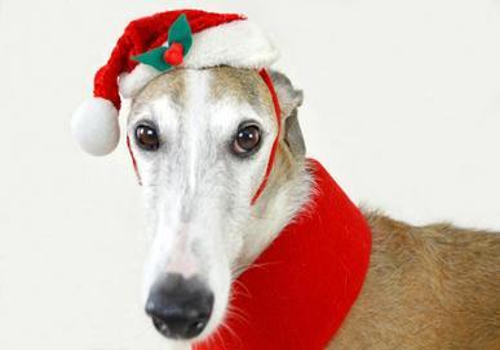

[{'generated_text': 'there is a dog wearing a santa hat and scarf'}]

In [20]:
#from helper import load_image, get_generation
from IPython.display import display

image_url = 'https://free-images.com/sm/9596/dog_animal_greyhound_983023.jpg'

image = load_image(image_url)
display(image.resize((500, 350)))
get_completion(image_url)

In [ ]:
#from helper import load_image, get_generation
from IPython.display import display

image_url = 'https://free-images.com/lg/9e46/white_bengal_tiger_tiger_0.jpg'

image = load_image(image_url)
display(image.resize((500, 350)))
get_completion(image_url)

## Captioning with `gr.Interface()`

#### gr.Image()
- The `type` parameter is the format that the `fn` function expects to receive as its input.  If `type` is `numpy` or `pil`, `gr.Image()` will convert the uploaded file to this format before sending it to the `fn` function.
- If `type` is `filepath`, `gr.Image()` will temporarily store the image and provide a string path to that image location as input to the `fn` function.
- gr.Image requires the installation of gradio and the set up of a custom PORT1 environment variable. 

In [21]:
#Get port1 from the environment
#import os
PORT1 = int(os.environ.get('PORT1', 7860))  # Default to 7860 if PORT1 is not set
#print(f"Running on port: {PORT1}")

Running on port: 7860


In [22]:
%pip install gradio

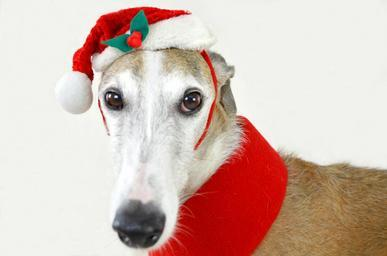

In [23]:
#Load Images 
from PIL import Image
#Image1
image1 = Image.open('./Building_Generative_AI_Applications_with_Gradio/Image_Captioning_app/christmas_dog.jpeg')
image1

In [ ]:
#Load Images 
from PIL import Image
#Image1
image10 = Image.open('./Building_Generative_AI_Applications_with_Gradio/Image_Captioning_app/white_bengal_tiger.jpg')
image10

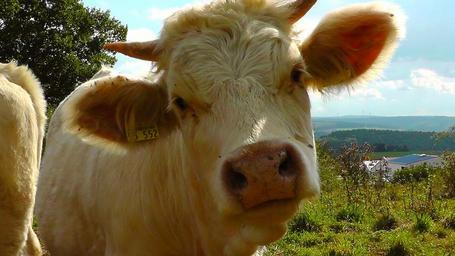

In [24]:
#Image2
image2 = Image.open('./Building_Generative_AI_Applications_with_Gradio/Image_Captioning_app/cow.jpeg')
image2

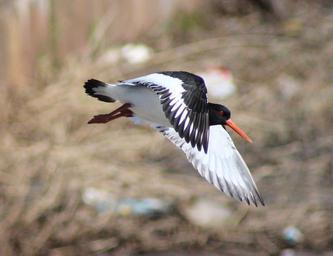

In [25]:
#Image3
image3 = Image.open('./Building_Generative_AI_Applications_with_Gradio/Image_Captioning_app/bird_flight.jpeg')
image3

In [26]:
import gradio as gr 

def image_to_base64_str(pil_image):
    byte_arr = io.BytesIO()
    pil_image.save(byte_arr, format='PNG')
    byte_arr = byte_arr.getvalue()
    return str(base64.b64encode(byte_arr).decode('utf-8'))

def captioner(image):
    base64_image = image_to_base64_str(image)
    result = get_completion(base64_image)
    return result[0]['generated_text']

gr.close_all()
demo = gr.Interface(fn=captioner,
                    inputs=[gr.Image(label="Upload image", type="pil")],
                    outputs=[gr.Textbox(label="Caption")],
                    title="Image Captioning with BLIP",
                    description="Caption any image using the BLIP model",
                    allow_flagging="never",
                    #examples=["christmas_dog.jpeg", "bird_flight.jpeg", "cow.jpeg"])
                    examples=[image1, image2, image3])

demo.launch(share=True, inline=True, server_port=int(os.environ['PORT1']))


Closing server running on port: 7860
Closing server running on port: 7860


/usr/local/python/3.12.1/lib/python3.12/site-packages/gradio/interface.py:399: UserWarning: The `allow_flagging` parameter in `Interface` is deprecated.Use `flagging_mode` instead.
  warnings.warn(


* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://590bcfb57abd0223e1.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [13]:
gr.close_all()

Closing server running on port: 7860


In [27]:
import gradio as gr
import io
import base64
from PIL import Image
import os

# Define the function to convert an image to a base64 string
def image_to_base64_str(pil_image):
    byte_arr = io.BytesIO()
    pil_image.save(byte_arr, format='PNG')
    byte_arr = byte_arr.getvalue()
    return str(base64.b64encode(byte_arr).decode('utf-8'))

# Mockup for get_completion (replace with your actual function)
def get_completion(base64_image):
    return [{"generated_text": "This is a sample caption for the image."}]

# Define the main captioning function
def captioner(image):
    base64_image = image_to_base64_str(image)
    result = get_completion(base64_image)
    return result[0]['generated_text']

# Close any existing Gradio instances
gr.close_all()

# Define and launch the Gradio app
demo = gr.Interface(
    fn=captioner,
    inputs=[gr.Image(label="Upload image", type="pil")],
    outputs=[gr.Textbox(label="Caption")],
    title="Image Captioning with BLIP",
    description="Caption any image using the BLIP model",
    allow_flagging="never",
)

# Launch the app
demo.launch(share=True, inline=True, server_port=int(os.environ['PORT1']))


/usr/local/python/3.12.1/lib/python3.12/site-packages/gradio/interface.py:399: UserWarning: The `allow_flagging` parameter in `Interface` is deprecated.Use `flagging_mode` instead.
  warnings.warn(


Closing server running on port: 7860
Closing server running on port: 7860
Closing server running on port: 7860
* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://9af616f8e6a78f70db.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


STILL TO SOLVE THE ISSUE ON LOCAL URL 

In [14]:
import gradio as gr
import base64
import io

def image_to_base64_str(pil_image):
    byte_arr = io.BytesIO()
    pil_image.save(byte_arr, format='PNG')
    byte_arr = byte_arr.getvalue()
    return str(base64.b64encode(byte_arr).decode('utf-8'))

def captioner(image):
    base64_image = image_to_base64_str(image)
    result = get_completion(base64_image)
    
    # Debugging: Print the result to inspect its content
    print("API result:", result)
    
    if result and isinstance(result, list) and 'generated_text' in result[0]:
        return result[0]['generated_text']
    else:
        return "Error: Could not generate caption"

gr.close_all()
demo = gr.Interface(fn=captioner,
                    inputs=[gr.Image(label="Upload image", type="pil")],
                    outputs=[gr.Textbox(label="Caption")],
                    title="Image Captioning with BLIP",
                    description="Caption any image using the BLIP model",
                    allow_flagging="never",
                    examples=[image1, image2, image3])

demo.launch(share=True, server_port=int(os.environ['PORT1']))

Closing server running on port: 7860


/usr/local/python/3.12.1/lib/python3.12/site-packages/gradio/interface.py:399: UserWarning: The `allow_flagging` parameter in `Interface` is deprecated.Use `flagging_mode` instead.
  warnings.warn(


* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://d3a4fd3b7c494667b1.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [28]:
import gradio as gr
import base64
import io

def image_to_base64_str(pil_image):
    byte_arr = io.BytesIO()
    pil_image.save(byte_arr, format='PNG')
    byte_arr = byte_arr.getvalue()
    return str(base64.b64encode(byte_arr).decode('utf-8'))

def captioner(image):
    base64_image = image_to_base64_str(image)
    print("Base64 image:", base64_image[:100])  # Print the first 100 characters of the base64 image for debugging

    try:
        result = get_completion(base64_image)
        print("API result:", result)
    except Exception as e:
        print("Error during API call:", e)
        return "Error: Could not generate caption"

    if result and isinstance(result, list) and 'generated_text' in result[0]:
        return result[0]['generated_text']
    else:
        return "Error: Could not generate caption"

gr.close_all()
demo = gr.Interface(fn=captioner,
                    inputs=[gr.Image(label="Upload image", type="pil")],
                    outputs=[gr.Textbox(label="Caption")],
                    title="Image Captioning with BLIP",
                    description="Caption any image using the BLIP model",
                    allow_flagging="never",
                    examples=[image1, image2, image3])

demo.launch(share=True, server_port=int(os.environ['PORT1']))

Closing server running on port: 7860
Closing server running on port: 7860
Closing server running on port: 7860
Closing server running on port: 7860


/usr/local/python/3.12.1/lib/python3.12/site-packages/gradio/interface.py:399: UserWarning: The `allow_flagging` parameter in `Interface` is deprecated.Use `flagging_mode` instead.
  warnings.warn(


* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://f659aa7703f75c45d4.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [11]:
!pip install --upgrade gradio

In [12]:
import gradio as gr
import base64
import io

def image_to_base64_str(pil_image):
    byte_arr = io.BytesIO()
    pil_image.save(byte_arr, format='PNG')
    byte_arr = byte_arr.getvalue()
    return str(base64.b64encode(byte_arr).decode('utf-8'))

def captioner(image):
    base64_image = image_to_base64_str(image)
    print("Base64 image:", base64_image[:100])  # Print the first 100 characters of the base64 image for debugging

    try:
        result = get_completion(base64_image)
        print("API result:", result)
    except Exception as e:
        print("Error during API call:", e)
        return "Error: Could not generate caption"

    if result and isinstance(result, list) and 'generated_text' in result[0]:
        return result[0]['generated_text']
    else:
        return "Error: Could not generate caption"

gr.close_all()
demo = gr.Interface(fn=captioner,
                    inputs=[gr.Image(label="Upload image", type="pil")],
                    outputs=[gr.Textbox(label="Caption")],
                    title="Image Captioning with BLIP",
                    description="Caption any image using the BLIP model",
                    allow_flagging="never",
                    examples=[image1, image2, image3])

#demo.launch(share=True, server_port=int(os.environ['PORT1']))
demo.launch(share=True, server_port=7860)


/usr/local/python/3.12.1/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/usr/local/python/3.12.1/lib/python3.12/site-packages/gradio/interface.py:399: UserWarning: The `allow_flagging` parameter in `Interface` is deprecated.Use `flagging_mode` instead.
  warnings.warn(


* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://82fd675bb6452c7547.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [29]:
demo.launch(share=True, inline=True, server_port=8000)


Rerunning server... use `close()` to stop if you need to change `launch()` parameters.
----
* Running on public URL: https://f659aa7703f75c45d4.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
